In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributed as dist
from tqdm.notebook import tqdm

from allreduce import butterfly_allreduce, ring_allreduce, measure_communication_time

In [2]:
def wrap_allreduce(tensor, rank, world_size):
    return dist.all_reduce(tensor)

In [3]:
sizes = [1024, 2000, 5000, 10000, 20000, 50000, 75000, 100000]
sizes = [(x // 32) * 32 for x in sizes]
allreduces = dict(
    butterfly=butterfly_allreduce,
    ring=ring_allreduce,
    torch=wrap_allreduce
)
num_procs = [2 ** n for n in range(5)]
results = []

for name, alg in allreduces.items():
    for size in tqdm(sizes):
        for num_proc in num_procs:
            time = measure_communication_time(alg, num_proc, size)
            results.append(dict(
                time=time,
                size=size,
                num_proc=num_proc,
                algorithm=name
            ))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
res = pd.DataFrame(results)
res.head()

,time,size,num_proc,algorithm
0,0.027924,1024,1,butterfly
1,0.044794,1024,2,butterfly
2,0.077949,1024,4,butterfly
3,0.185596,1024,8,butterfly
4,0.373554,1024,16,butterfly


In [8]:
res.groupby('algorithm').time.mean()

algorithm
butterfly    0.147361
ring         0.146859
torch        0.141485
Name: time, dtype: float64

In [16]:
res[(res.algorithm=='ring')&(res.num_proc==1)]

32

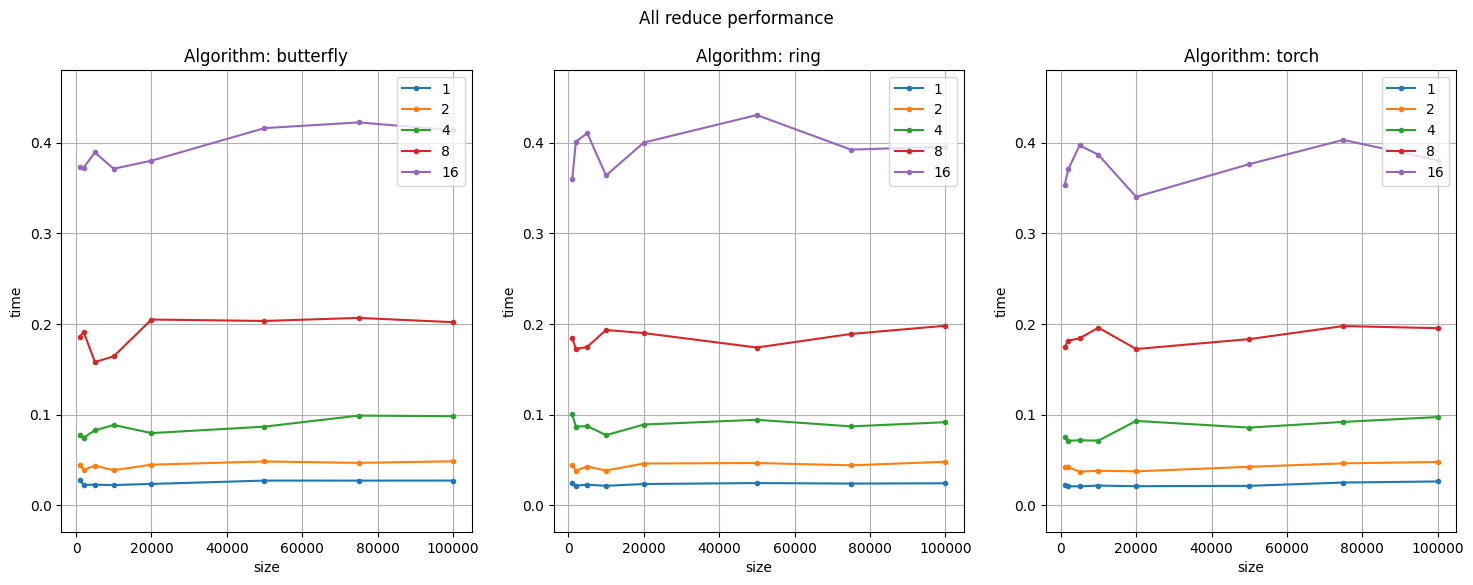

In [24]:
# markers = ['.', '*', '<']
alg_groups = res.algorithm.unique()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('All reduce performance')
for i, alg in enumerate(alg_groups):
    ax = axs[i]
    ax.grid(True)
    ax.set_ylim(res.time.min()-0.05, res.time.max()+0.05)
    
    num_procs = res[res.algorithm == alg].num_proc.unique()
    for num_proc in num_procs:
        cur_data = res[res.algorithm == alg]
        ax.plot(
            cur_data[cur_data.num_proc==num_proc]['size'],
            cur_data[cur_data.num_proc==num_proc]['time'],
            marker='.'
        )

    ax.set_xlabel('size')
    ax.set_ylabel('time')
    ax.legend(num_procs)
    ax.set_title(f'Algorithm: {alg}')

plt.show()

In [41]:
from matplotlib.lines import Line2D

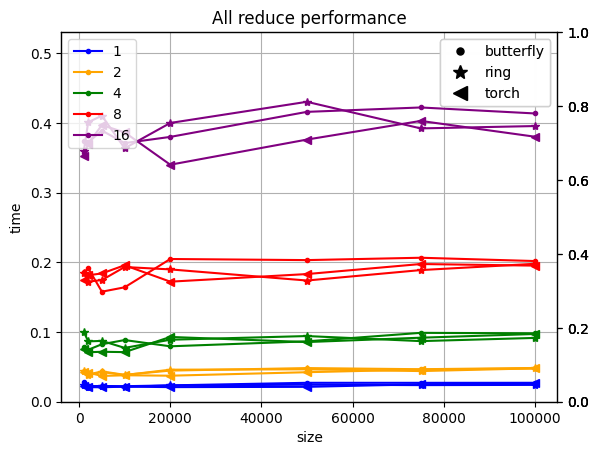

In [50]:
markers = ['.', '*', '<']
colors = ['blue', 'orange', 'green', 'red', 'purple']
alg_groups = res.algorithm.unique()

fig, ax = plt.subplots()
ax.set_title('All reduce performance')
for marker, alg in zip(markers, alg_groups):
    ax.grid(True)
    ax.set_ylim(top=res.time.max()+0.1)
    num_procs = res[res.algorithm == alg].num_proc.unique()
    for i, num_proc in enumerate(num_procs):
        cur_data = res[res.algorithm == alg]
        ax.plot(
            cur_data[cur_data.num_proc==num_proc]['size'],
            cur_data[cur_data.num_proc==num_proc]['time'],
            marker=marker, color=colors[i]
        )

    ax.set_xlabel('size')
    ax.set_ylabel('time')
    ax.legend(num_procs, loc='upper left')

    aa = []
    ax2 = ax.twinx()
    for marker in markers:
        a = Line2D(
            [], [], color='black', 
            marker=marker, linestyle='None',
            markersize=10
        )
        aa.append(a)

    ax2.legend(aa, [model.split('/')[-1] for model in alg_groups], loc='upper right')

plt.show()